# Model training

## LightGBM

In [3]:
import pandas as pd, numpy as np
from typing import Iterator, Tuple
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

### Carga de datos

In [4]:
# Obtener .parquet de datos muestreados
SAMPLE_PATH = 'D:/2025/UVG/Tesis/repos/backend/features_sampled_without_idle_rows/sample_features.parquet'

data = pd.read_parquet(SAMPLE_PATH)

# Renombrar columna "Altitud (m)" a "Altitud"
data = data.rename(columns={"Altitud (m)": "Altitud"})

data.head()

,Placa,trip_id,block_id,LINEA,DIR,proxima_est_teorica,Fecha,dist_a_prox_m,dist_estacion_m,vel_mps,...,dist_m,time_diff,dwell_same_xy_s,is_no_progress,progress_event,hour,dow,is_weekend,is_peak,ETA_proxima_est_s
0,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:38:23,2507.478516,361.775177,0.0,...,320.33194,60.0,0.0,0,0,9,4,0,1,657.0
1,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:39:23,2507.478516,361.775177,0.0,...,320.33194,60.0,60.0,1,0,9,4,0,1,597.0
2,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:40:23,2507.478516,361.775177,0.0,...,320.33194,60.0,120.0,1,0,9,4,0,1,537.0
3,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:41:23,2507.478516,361.775177,0.0,...,320.33194,60.0,180.0,1,0,9,4,0,1,477.0
4,49,1,1,Linea_12,IDA,MONTE MARÍA,2024-01-12 09:42:23,2507.478516,361.775177,0.0,...,320.33194,60.0,240.0,1,0,9,4,0,1,417.0


In [5]:
# Preparar datos

# Columnas iniciales
str_cols = ["Placa","trip_id","block_id","LINEA","DIR","proxima_est_teorica"]
dt_cols  = ["Fecha"]
float_cols = [
    "dist_a_prox_m","dist_estacion_m","vel_mps","Altitud","s_m","dist_m",
    "time_diff","dwell_same_xy_s","ETA_proxima_est_s"
]
int_cols = ["hour","dow"]
boolish_cols = ["is_no_progress","progress_event","is_weekend","is_peak"]

# Convertir tipos
for c in str_cols:
    data[c] = data[c].astype("category")
for c in dt_cols:
    data[c] = pd.to_datetime(data[c])
for c in float_cols:
    data[c] = data[c].astype("float32")
for c in int_cols:
    data[c] = data[c].astype("int32")
for c in boolish_cols:
    data[c] = data[c].astype("bool")

### Train / valid / test split

In [6]:
df = data.copy()
dev_df = df[df["Fecha"] < "2025-04-01"]   # TODO lo anterior a abril 2025
test_df = df[df["Fecha"] >= "2025-04-01"] # TODO abril 2025 en adelante

In [5]:
def day_based_time_cv_full(
    df: pd.DataFrame,
    day_col: str = "Fecha",
    min_train_days: int = 30,   # entrena al menos 30 días antes del 1er fold
    valid_days: int = 2,        # ventana de validación por fold
    step_days: int = 7,         # cuánto avanzas la ventana por fold (stride)
    embargo_days: int = 0,      # buffer entre train y valid (opcional)
    max_splits = None,  # None = hasta agotar el timeline
) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    d = df.copy()
    d["__day__"] = pd.to_datetime(d[day_col]).dt.normalize()
    unique_days = np.array(sorted(d["__day__"].unique()))
    total_days = len(unique_days)

    start_valid = min_train_days + embargo_days
    splits = 0
    while start_valid + valid_days <= total_days:
        train_last = start_valid - embargo_days - 1
        valid_start = start_valid
        valid_end   = start_valid + valid_days  # exclusivo

        train_days = set(unique_days[:train_last+1])
        valid_days_set = set(unique_days[valid_start:valid_end])

        mask_train = d["__day__"].isin(train_days).values
        mask_valid = d["__day__"].isin(valid_days_set).values

        tr_idx = df.index[mask_train].values
        va_idx = df.index[mask_valid].values

        yield np.sort(tr_idx), np.sort(va_idx)

        splits += 1
        if (max_splits is not None) and (splits >= max_splits):
            break
        start_valid += step_days  # avanza la ventana

In [6]:
def summarize_splits(df, splits, day_col="Fecha", key_cols=("Placa","trip_id")):
    df = df.copy()
    df["__day__"] = pd.to_datetime(df[day_col]).dt.normalize()
    df["__trip_key__"] = list(zip(*[df[c].astype(str) for c in key_cols]))  # (Placa, trip_id)

    for i, (tr_idx, va_idx) in enumerate(splits, 1):
        tr_days = df.loc[tr_idx, "__day__"].unique()
        va_days = df.loc[va_idx, "__day__"].unique()

        print(f"\nFold {i}")
        print("  Train days:", tr_days.min(), "→", tr_days.max(), f"({len(tr_days)} días, {len(tr_idx):,} filas)")
        print("  Valid days:", va_days.min(), "→", va_days.max(), f"({len(va_days)} días, {len(va_idx):,} filas)")
        day_overlap = set(tr_days) & set(va_days)
        print("  Day overlap? ", "YES" if day_overlap else "NO")

        tr_keys = set(df.loc[tr_idx, "__trip_key__"].unique())
        va_keys = set(df.loc[va_idx, "__trip_key__"].unique())
        key_overlap = tr_keys & va_keys
        print("  Trip overlap (Placa,trip_id)? ", f"YES ({len(key_overlap)})" if key_overlap else "NO")


In [ ]:
splits = list(day_based_time_cv_full(
    dev_df,
    day_col="Fecha",
    min_train_days=30,
    valid_days=5,
    step_days=30,        # un fold por mes
    embargo_days=0,     # buffer de 0 días
    max_splits=None     # None = hasta el final del timeline
))


# Verificar los splits
summarize_splits(dev_df, splits)


Fold 1
  Train days: 2024-01-01 00:00:00 → 2024-01-30 00:00:00 (30 días, 322,634 filas)
  Valid days: 2024-01-31 00:00:00 → 2024-02-04 00:00:00 (5 días, 45,113 filas)
  Day overlap?  NO
  Trip overlap (Placa,trip_id)?  YES (2)

Fold 2
  Train days: 2024-01-01 00:00:00 → 2024-02-29 00:00:00 (60 días, 668,305 filas)
  Valid days: 2024-03-01 00:00:00 → 2024-03-05 00:00:00 (5 días, 53,119 filas)
  Day overlap?  NO
  Trip overlap (Placa,trip_id)?  YES (3)

Fold 3
  Train days: 2024-01-01 00:00:00 → 2024-03-30 00:00:00 (90 días, 962,035 filas)
  Valid days: 2024-03-31 00:00:00 → 2024-04-04 00:00:00 (5 días, 52,903 filas)
  Day overlap?  NO
  Trip overlap (Placa,trip_id)?  YES (4)

Fold 4
  Train days: 2024-01-01 00:00:00 → 2024-04-29 00:00:00 (120 días, 1,311,520 filas)
  Valid days: 2024-04-30 00:00:00 → 2024-05-04 00:00:00 (5 días, 40,338 filas)
  Day overlap?  NO
  Trip overlap (Placa,trip_id)?  YES (6)

Fold 5
  Train days: 2024-01-01 00:00:00 → 2024-05-29 00:00:00 (150 días, 1,627,891 

### Entrenamiento

In [8]:
# Definir características y objetivo

categorical_features = ["LINEA","DIR","proxima_est_teorica"]
numeric_features = [
    "dist_a_prox_m","dist_estacion_m",
    "vel_mps","Altitud","s_m","dist_m",
    "time_diff","dwell_same_xy_s","hour","dow",
    "is_no_progress","progress_event","is_weekend","is_peak"
]

feature_cols = categorical_features + numeric_features
target_col = "ETA_proxima_est_s"

In [10]:
# Para métricas

SLA_THRESH = [60, 120, 180]    # segundos

def compute_metrics(y_true, y_pred, sla_thresh=SLA_THRESH):
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(root_mean_squared_error(y_true, y_pred))
    abs_err = np.abs(y_pred - y_true)
    sla = {f"sla_le_{t}s": float((abs_err <= t).mean()) for t in sla_thresh}
    return {"mae": mae, "rmse": rmse, **sla}


# Definir parámetros
params = {
    "objective": "regression",
    "metric": ["mae","rmse"],
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 200,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "max_bin": 255,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "verbose": 1,
    "seed": SEED
}

In [7]:
SEED = 25

Validación cruzada

In [11]:
fold_results = []
models = []
best_iters = []
fi_gain_list = []

for fold, (tr_idx, va_idx) in enumerate(splits, 1):
    
    print(f"\n=== Fold {fold} ===")
    
    X_train = dev_df.loc[tr_idx, feature_cols]
    y_train = dev_df.loc[tr_idx, target_col]
    X_valid = dev_df.loc[va_idx, feature_cols]
    y_valid = dev_df.loc[va_idx, target_col]
    
    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=True)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features, free_raw_data=True)
    
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_valid],
        valid_names=[f"valid{fold}"],
        num_boost_round=3000,
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
    )
    
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    metrics = compute_metrics(y_valid.values, y_pred, SLA_THRESH)
    metrics["fold"] = fold
    metrics["best_iter"] = int(model.best_iteration)
    fold_results.append(metrics)
    best_iters.append(model.best_iteration)
    models.append(model)

    # importancias (gain)
    fi_gain = pd.DataFrame({
        "feature": feature_cols,
        "gain": model.feature_importance(importance_type="gain"),
        "fold": fold,
    })
    fi_gain_list.append(fi_gain)


=== Fold 1 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 322634, number of used features: 17
[LightGBM] [Info] Start training from score 275.678341

=== Fold 2 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 668305, number of used features: 17
[LightGBM] [Info] Start training from score 274.850839

=== Fold 3 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051533 seconds.
You can set `force_row_wise=tr

In [12]:
cv_df = pd.DataFrame(fold_results).set_index("fold")
print("\n=== Métricas por fold ===")
print(cv_df)

print("\n=== Promedio CV ± std ===")
summary = cv_df.agg(["mean","std"])
print(summary)

avg_best_iter = int(np.mean(best_iters))
print(f"\nIteraciones promedio (best_iteration): {avg_best_iter}")

fi_gain_all = pd.concat(fi_gain_list, ignore_index=True)
fi_gain_mean = fi_gain_all.groupby("feature")["gain"].mean().sort_values(ascending=False)
print("\nTop-20 features por gain promedio:")
print(fi_gain_mean.head(20))


=== Métricas por fold ===
             mae        rmse  sla_le_60s  sla_le_120s  sla_le_180s  best_iter
fold                                                                         
1     110.239148  305.263848    0.640591     0.793917     0.861570        515
2      89.619609  202.398015    0.640317     0.811367     0.880024        313
3     107.678575  322.144033    0.647752     0.809198     0.875206        742
4     105.644139  291.310490    0.650206     0.805270     0.870023       1046
5      90.556050  242.656765    0.667653     0.822287     0.887538       1152
6      97.643400  319.963239    0.685164     0.836701     0.895897        582
7      98.614714  281.116513    0.665371     0.819914     0.881250       3000
8     114.477586  287.500322    0.610239     0.773504     0.848805        994
9     134.672916  335.105836    0.574890     0.742899     0.821036       1165
10    135.344141  366.560378    0.612161     0.768495     0.836661       1685
11    116.476928  332.094161    0.607

In [14]:
# Guardar modelos entrenados por fold
import os

model_dir = "D:/2025/UVG/Tesis/repos/backend/models/lightgbm/cross_validation_models"
os.makedirs(model_dir, exist_ok=True)

for fold, model in enumerate(models, 1):
    model.save_model(f"{model_dir}/lgb_model_fold{fold}.txt")
    
# Guardar métricas CV
cv_df.to_csv(f"{model_dir}/cv_metrics.csv")
# Guardar importancias
fi_gain_all.to_csv(f"{model_dir}/cv_feature_importances_gain.csv", index=False)

# Guardar parámetros usados
import json
with open(f"{model_dir}/lgb_params.json", "w") as f:
    json.dump(params, f, indent=4)

Modelo final

In [11]:
# Obtener el archivo guardado de cv metrics
import pandas as pd
cv_metrics = pd.read_csv("D:/2025/UVG/Tesis/repos/backend/models/lightgbm/cross_validation_models/cv_metrics.csv", index_col="fold")
best_iters = cv_metrics["best_iter"]

# Calcular la mediana de best_iters para usar en el modelo final
final_rounds = int(np.median(best_iters))
print(f"Usando {final_rounds} iteraciones para el modelo final.")

Usando 896 iteraciones para el modelo final.


In [18]:
# Split temporal interno (5% final)
df_all = dev_df.copy()
cutoff = df_all['Fecha'].quantile(0.95)

# Viajes “tardíos” = viajes cuyo último timestamp cae en el 5% final
trip_last = df_all.groupby("trip_id", observed=False)["Fecha"].max()
late_trip_ids = set(trip_last[trip_last >= cutoff].index)

valid_df = df_all[df_all["trip_id"].isin(late_trip_ids)].copy()
train_df = df_all[~df_all["trip_id"].isin(late_trip_ids)].copy()

print('Comenzando entrenamiento final...')

lgb_train_full = lgb.Dataset(
    train_df[feature_cols],
    label=train_df[target_col],
    categorical_feature=categorical_features
)

lgb_valid_full = lgb.Dataset(
    valid_df[feature_cols],
    label=valid_df[target_col],
    categorical_feature=categorical_features
)

# 3) ENTRENAMIENTO FINAL con registro de métricas
evals_result = {}
final_params = {**params, "metric": ["mae", "rmse"]}  # registra métricas

final_model = lgb.train(
    final_params,
    lgb_train_full,
    num_boost_round=final_rounds,
    valid_sets=[lgb_train_full, lgb_valid_full],
    valid_names=["train", "valid"],
    callbacks=[lgb.log_evaluation(50), lgb.record_evaluation(evals_result), lgb.early_stopping(100)]  # imprime cada 50 iter
)

Comenzando entrenamiento final...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 3739948, number of used features: 17
[LightGBM] [Info] Start training from score 283.573188
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 130.446	train's rmse: 323.857	valid's l1: 128.669	valid's rmse: 323.912
[100]	train's l1: 119.313	train's rmse: 308.841	valid's l1: 118.274	valid's rmse: 313.272
[150]	train's l1: 116.398	train's rmse: 302.746	valid's l1: 115.948	valid's rmse: 310.159
[200]	train's l1: 114.586	train's rmse: 298.749	valid's l1: 114.62	valid's rmse: 308.344
[250]	train's l1: 113.323	train's rmse: 295.829	valid's l1: 113.704	valid's rmse: 306.981
[300]	train's l1: 112.304	train's rmse: 293.44

In [16]:
import os, json

# Métricas en set de prueba
y_test_pred = final_model.predict(test_df[feature_cols], num_iteration=final_model.best_iteration)
y_test = test_df[target_col]

test_metrics = compute_metrics(y_test.values, y_test_pred, SLA_THRESH)
print("\n=== Métricas en set de prueba (LightGBM final) ===")

for k, v in test_metrics.items():
    print(f"{k}: {v*100:.2f}%" if k.startswith("sla_") else f"{k}: {v:.2f} s")
    
# Guardar modelo final
final_dir = "D:/2025/UVG/Tesis/repos/backend/models/lightgbm/final"
os.makedirs(final_dir, exist_ok=True)
final_model.save_model(f"{final_dir}/lgb_final_model.txt")

# Guardar métricas del set de prueba
with open(f"{final_dir}/test_metrics.json", "w") as f:
    json.dump({k: float(v) for k, v in test_metrics.items()}, f, indent=2)
    
# Guardar parámetros y metadatos del modelo final

final_meta = {
    "final_rounds": final_rounds,
    "params": params,
    "feature_cols": feature_cols,
    "target_col": target_col,
}

with open(f"{final_dir}/final_meta.json", "w") as f:
    json.dump(final_meta, f, indent=4)
    
pd.DataFrame({
    "Fecha": test_df["Fecha"].values,
    "Placa": test_df["Placa"].astype(str).values if "Placa" in test_df.columns else None,
    "ETA_true": test_df[target_col].values,
    "ETA_pred": y_test_pred,
    "abs_error": np.abs(test_df[target_col].values - y_test_pred)
}).to_csv(f"{final_dir}/test_predictions.csv", index=False)


=== Métricas en set de prueba (LightGBM final) ===
mae: 123.73 s
rmse: 349.30 s
sla_le_60s: 60.40%
sla_le_120s: 76.89%
sla_le_180s: 84.53%


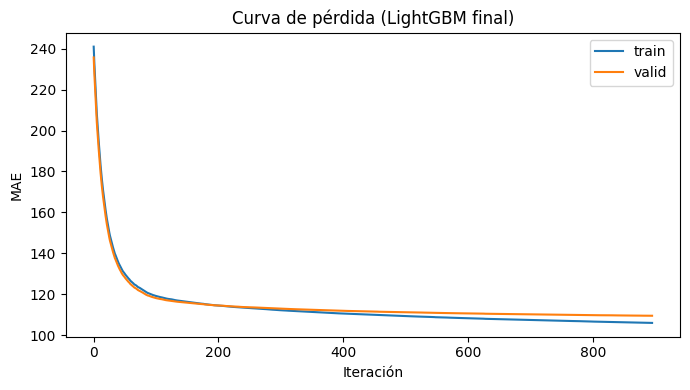

In [17]:
# Graficar curva de entrenamiento (pérdida)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(evals_result["train"]["l1"])
plt.plot(evals_result["valid"]["l1"])
plt.legend(["train","valid"])
plt.xlabel("Iteración")
plt.ylabel("MAE")
plt.title("Curva de pérdida (LightGBM final)")
plt.tight_layout()
plt.savefig(f"{final_dir}/lightgbm_loss_curve_l1.png", dpi=150)
plt.show()
plt.close()

# Persistir el historial para usarlo después sin re-entrenar
import json, os
os.makedirs(final_dir, exist_ok=True)
with open(f"{final_dir}/evals_result.json", "w") as f:
    json.dump(evals_result, f, indent=2)

In [11]:
# Desglose por línea
def group_report(df, y_true, y_pred, by=["LINEA","DIR"]):
    tmp = df.copy()
    tmp["y_true"] = y_true
    tmp["y_pred"] = y_pred
    tmp["abs_err"] = (y_true - y_pred).abs()
    agg = tmp.groupby(by).apply(
        lambda g: pd.Series({
            "MAE": g["abs_err"].mean(),
            "RMSE": (( (g["y_true"]-g["y_pred"])**2 ).mean())**0.5,
            "SLA<=60": (g["abs_err"]<=60).mean(),
            "SLA<=120": (g["abs_err"]<=120).mean(),
            "SLA<=180": (g["abs_err"]<=180).mean(),
            "n": len(g)
        })
    ).reset_index()
    return agg

seg = group_report(test_df, test_df[target_col], y_test_pred, by=["LINEA","DIR"]).dropna()
print("\n=== TEST por LINEA,DIR ===")
print(seg.sort_values("MAE"))
seg.to_csv(f"{final_dir}/test_segment_metrics.csv", index=False)


=== TEST por LINEA,DIR ===
         LINEA       DIR         MAE        RMSE   SLA<=60  SLA<=120  \
5     Linea_12    VUELTA   39.656754  172.223846  0.857523  0.970544   
7   Linea_13-A       IDA   62.017257  117.755585  0.700338  0.875854   
26     Linea_7    VUELTA   70.205814  175.500924  0.715408  0.870615   
0      Linea_1  CIRCULAR   79.726634  285.667316  0.700769  0.873261   
23     Linea_6    VUELTA   79.769025  225.467536  0.688915  0.849450   
8   Linea_13-A    VUELTA   80.146882  213.889861  0.696761  0.848829   
16  Linea_18-B       IDA   81.833158  149.843556  0.608339  0.802640   
25     Linea_7       IDA  105.338360  324.074145  0.613196  0.824402   
10  Linea_13-B       IDA  119.525141  252.681566  0.538168  0.741221   
19     Linea_2       IDA  125.002045  376.659427  0.506031  0.709590   
22     Linea_6       IDA  134.211556  361.057522  0.558946  0.747372   
11  Linea_13-B    VUELTA  157.588820  315.494690  0.429134  0.615298   
4     Linea_12       IDA  179.819339

C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_9904\1854728084.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby(by).apply(


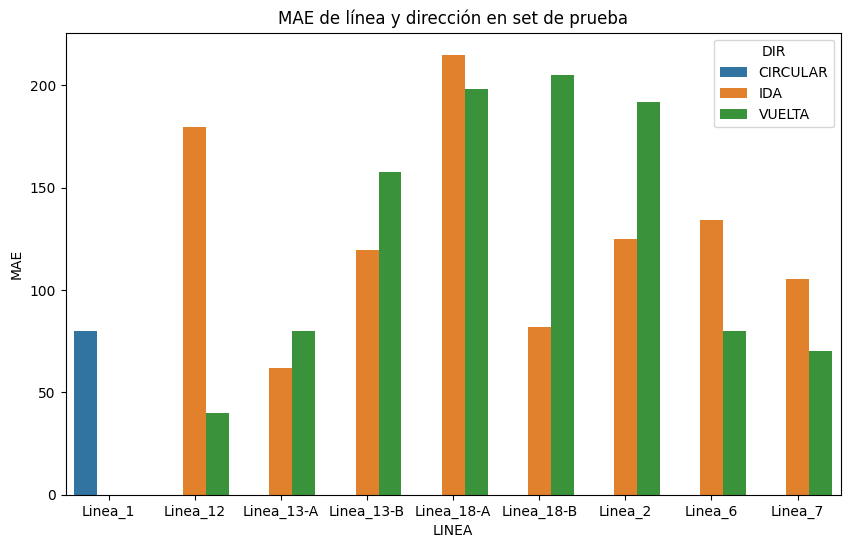

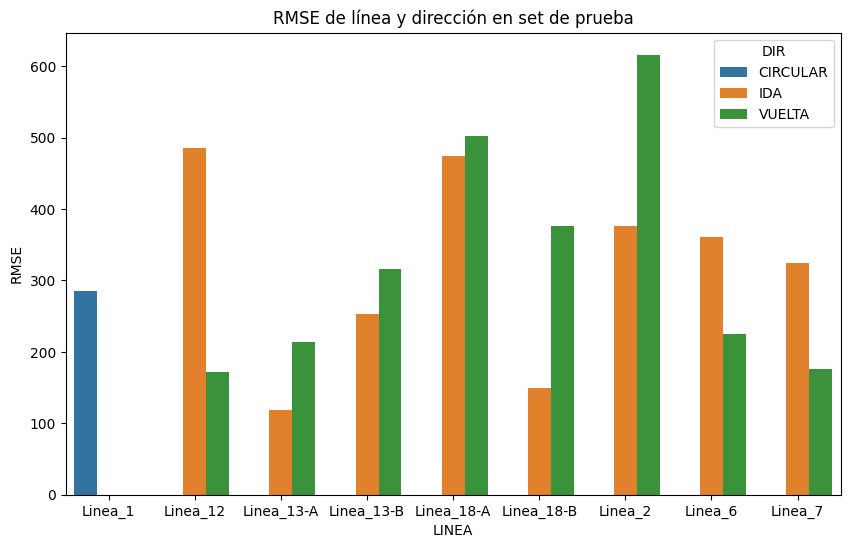

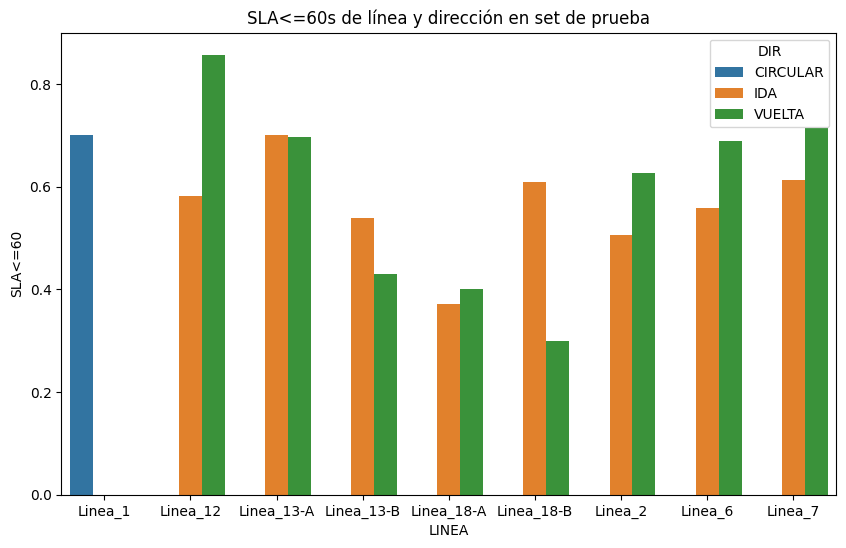

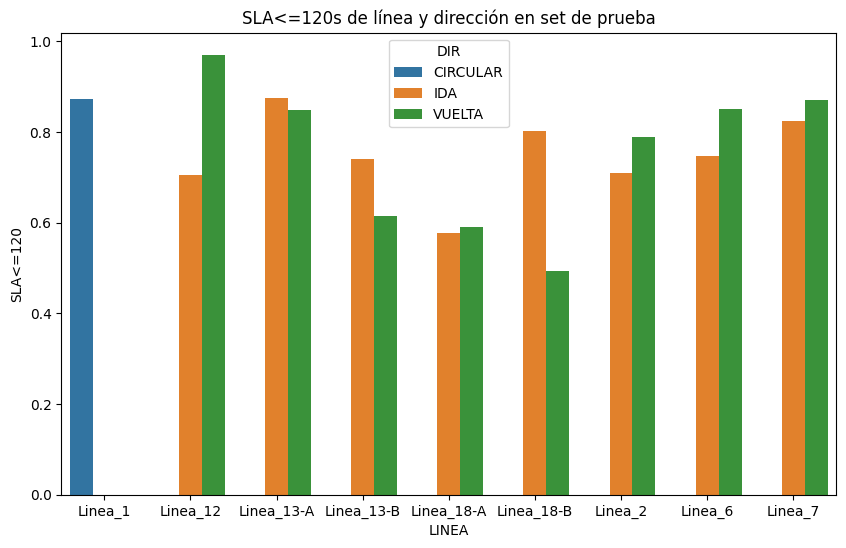

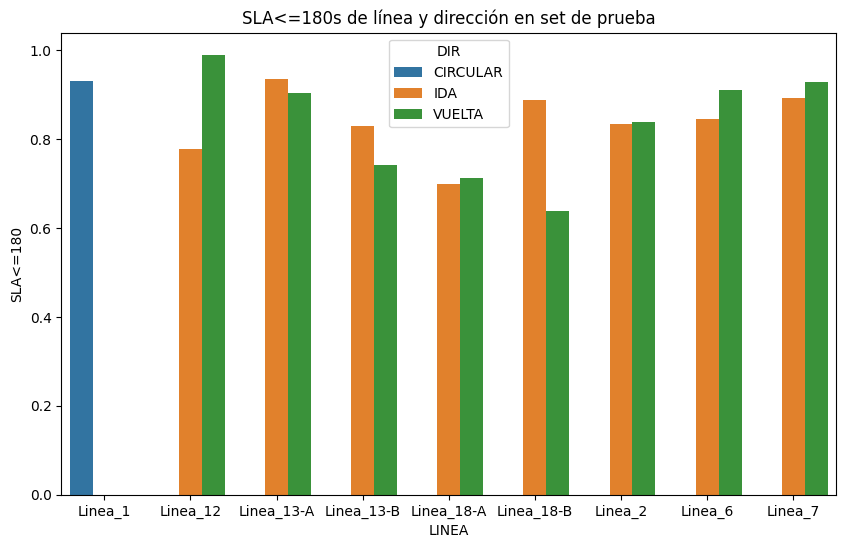

In [21]:
# Graficar desglose por línea
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("MAE"), x="LINEA", y="MAE", hue="DIR")
plt.title("MAE de línea y dirección en set de prueba")
plt.show()

# Ahora por RMSE
plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("RMSE"), x="LINEA", y="RMSE", hue="DIR")
plt.title("RMSE de línea y dirección en set de prueba")
plt.show()

# Y por SLAs 60, 120, 180 en una misma figura
plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("SLA<=60"), x="LINEA", y="SLA<=60", hue="DIR")

plt.title("SLA<=60s de línea y dirección en set de prueba")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("SLA<=120"), x="LINEA", y="SLA<=120", hue="DIR")
plt.title("SLA<=120s de línea y dirección en set de prueba")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=seg.sort_values("SLA<=180"), x="LINEA", y="SLA<=180", hue="DIR")
plt.title("SLA<=180s de línea y dirección en set de prueba")
plt.show()


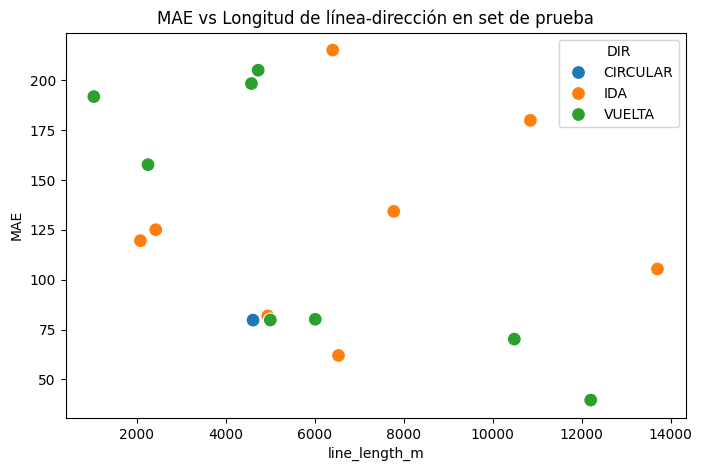

In [13]:
# Graficar MAE vs longitud de línea-dirección
import matplotlib.pyplot as plt
import seaborn as sns

# Agregar label a cada punto de línea-dirección
line_lengths = {('Linea_12', 'VUELTA'): 12200.808626648219, ('Linea_12', 'IDA'): 10845.387628085438, ('Linea_13-A', 'VUELTA'): 6012.190940444972, ('Linea_13-A', 'IDA'): 6534.035849736981, ('Linea_13-B', 'VUELTA'): 2254.6479853874207, ('Linea_13-B', 'IDA'): 2084.2982960687277, ('Linea_18-A', 'IDA'): 6404.3861825682725, ('Linea_18-A', 'VUELTA'): 4578.4823470769825, ('Linea_18-B', 'IDA'): 4945.409296311546, ('Linea_18-B', 'VUELTA'): 4729.713609387433, ('Linea_1', 'CIRCULAR'): 4614.474313630949, ('Linea_2', 'VUELTA'): 1037.4660760098993, ('Linea_2', 'IDA'): 2428.0171300075835, ('Linea_6', 'IDA'): 7776.4064575891425, ('Linea_6', 'VUELTA'): 5002.769566876154, ('Linea_7', 'IDA'): 13700.786008587509, ('Linea_7', 'VUELTA'): 10484.46220143616}
mae_vs_length = seg.copy()
mae_vs_length["line_length_m"] = mae_vs_length.apply(lambda row: line_lengths.get((row["LINEA"], row["DIR"]), np.nan), axis=1)
plt.figure(figsize=(8,5))
sns.scatterplot(data=mae_vs_length, x="line_length_m", y="MAE", hue="DIR", s=100)
plt.title("MAE vs Longitud de línea-dirección en set de prueba")
plt.show()

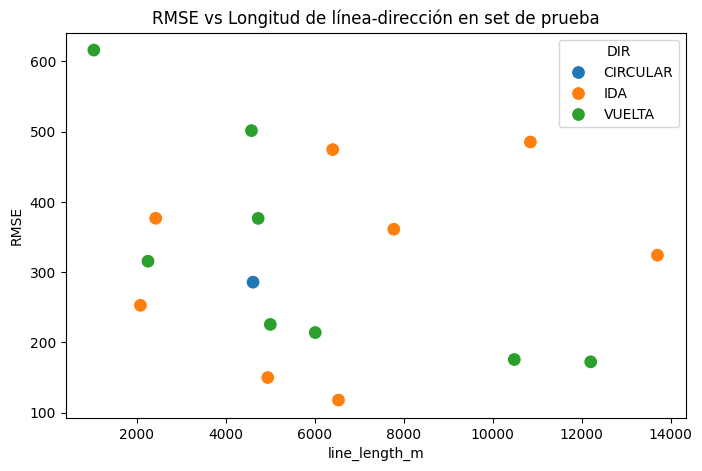

In [14]:
rmse_vs_length = seg.copy()
rmse_vs_length["line_length_m"] = rmse_vs_length.apply(lambda row: line_lengths.get((row["LINEA"], row["DIR"]), np.nan), axis=1)
plt.figure(figsize=(8,5))
sns.scatterplot(data=rmse_vs_length, x="line_length_m", y="RMSE", hue="DIR", s=100)
plt.title("RMSE vs Longitud de línea-dirección en set de prueba")
plt.show()

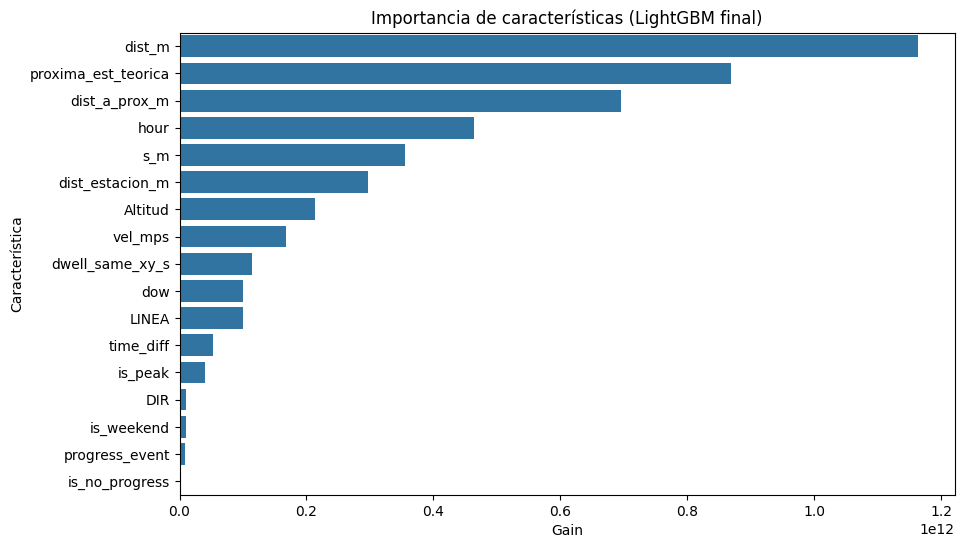

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo
final_dir = "D:/2025/UVG/Tesis/repos/backend/models/lightgbm/final"
final_model = lgb.Booster(model_file=final_dir + "/lgb_final_model.txt")

# Graficar importancias finales por gain (etiquetas incluidas)
fi_gain_final = pd.DataFrame({
    "Característica": feature_cols,
    "Gain": final_model.feature_importance(importance_type="gain"),
}).sort_values("Gain", ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(data=fi_gain_final.head(20), x="Gain", y="Característica")
plt.title("Importancia de características (LightGBM final)")
plt.show()